In [156]:
#Load Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [157]:
import numpy as np


from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import matplotlib.pyplot as plt

np.random.seed(42)

In [158]:
import os
path = os.listdir('')
classes = {'no_tumor': 0, 'pituitary_tumor': 1}

In [159]:
import cv2
X = []
Y = []
for cls in classes:
    pth = ''+cls
    for j in os.listdir(pth):
        img = cv2.imread(pth+'/'+j, 0)
        img = cv2.resize(img, (100,100))
        X.append(img)
        Y.append(classes[cls])

In [160]:
X = np.array(X)
Y = np.array(Y)

X_updated = X.reshape(len(X), -1)

In [161]:
np.unique(Y)

array([0, 1])

In [162]:
pd.Series(Y).value_counts()

1    827
0    395
dtype: int64

In [163]:
X.shape, X_updated.shape

((1222, 100, 100), (1222, 10000))

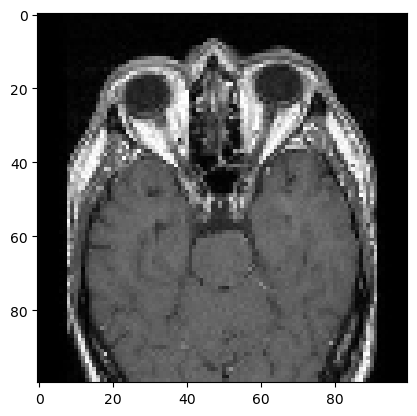

In [164]:
#Data Visualization
plt.imshow(X[0], cmap='gray')

In [165]:
#Prepare data

X_updated = X.reshape(len(X), -1)
X_updated.shape
#type(X_updated)

(1222, 10000)

In [166]:
#Split Data


xtrain, xtest, ytrain, ytest = train_test_split(X_updated, Y, random_state=10,
                                               test_size=.20)
xtrain.shape, xtest.shape, ytest.shape

((977, 10000), (245, 10000), (245,))

In [167]:

print(xtrain.max(), xtrain.min())
print(xtest.max(), xtest.min())
xtrain = xtrain/255
xtest = xtest/255
#print(xtrain.max(), xtrain.min())
#print(xtest.max(), xtest.min())
#print(xtrain[:,0:4])
print(ytest.shape)

255 0
255 0
(245,)


In [189]:
#Feature Selection: PCA
from sklearn.decomposition import PCA
import numpy as np


# Perform PCA to reduce the number of features to 10
pca = PCA(n_components=10)
xtrain_reduced = pca.fit_transform(xtrain)

xtest_reduced = pca.fit_transform(xtest)

#ytest_reduced = pca.fit_transform(ytest)

#ytrain_reduced = pca.transform(ytrain)

# The transformed data has 10 features
print(xtrain_reduced.shape)




(977, 10)


In [190]:
print(xtrain_reduced)
xtrain_reduced1 = xtrain_reduced[1:100,:]

[[-2.09782671e+00 -7.05392539e-01  8.84357103e-01 ... -3.28427080e+00
  -9.39518957e-04 -2.98586424e+00]
 [ 2.44131864e+01  8.95647831e+00  2.46379490e+00 ...  2.82311952e+00
   2.57699103e+00 -1.11527646e+00]
 [ 1.04527933e+00 -3.00284281e+00  3.14009970e+00 ...  2.17573203e+00
   2.09500544e+00  5.93364830e-01]
 ...
 [-2.58901009e-01 -4.16062640e+00  2.78140582e+00 ... -2.16780604e+00
   2.37774264e+00  2.49480225e+00]
 [ 4.18194073e+00 -2.82319083e+00 -3.11117863e+00 ... -1.92659162e-01
  -8.17063964e-01 -3.48357613e-01]
 [ 2.18338176e+00 -4.48589443e+00  1.27808970e+00 ...  4.83901235e-01
   3.40676499e+00  1.90149209e+00]]


In [191]:
print(xtrain_reduced1.shape)

(99, 10)


In [192]:
#Quantum SVM
n_qubits = len(xtrain_reduced[0])
n_qubits

10

In [193]:
dev_kernel = qml.device("default.qubit", wires=n_qubits)

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1

@qml.qnode(dev_kernel, interface="autograd")
def kernel(x1, x2):
    """The quantum kernel."""
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

In [194]:
def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

In [195]:
kernel(xtrain_reduced1[0], xtrain_reduced1[0])

tensor(1., requires_grad=True)

In [196]:
svm = SVC(kernel=kernel_matrix).fit(xtrain_reduced[1:20], ytrain[1:20])

In [197]:
predictions = svm.predict(xtest_reduced)
accuracy_score(predictions, ytest)

0.6693877551020408

In [188]:
type(kernel)

pennylane.qnode.QNode